In [ ]:
#development.ipynb
import environment_MARL
import data_classes

import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any, Tuple, Union, Dict
import distrax


import functools

class ScannedRNN(nn.Module):
    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, carry, x):
        """Applies the module."""
        rnn_state = carry
        ins, resets = x
        rnn_state = jnp.where(
            resets[:, np.newaxis],
            self.initialize_carry(ins.shape[0], ins.shape[1]),
            rnn_state,
        )
        new_rnn_state, y = nn.GRUCell(features=ins.shape[1])(rnn_state, ins)
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(batch_size, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (batch_size, hidden_size))


class ActorRNN(nn.Module):
    action_dim: Sequence[int]
    config: Dict

    @nn.compact
    def __call__(self, hidden, x):
        obs, dones, avail_actions = x
        embedding = nn.Dense(
            128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(obs)
        embedding = nn.relu(embedding)

        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)

        actor_mean = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(
            embedding
        )
        actor_mean = nn.relu(actor_mean)
        action_logits = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        unavail_actions = 1 - avail_actions
        action_logits = action_logits - (unavail_actions * 1e10)

        pi = distrax.Categorical(logits=action_logits)

        return hidden, pi


class CriticRNN(nn.Module):
    
    @nn.compact
    def __call__(self, hidden, x):
        world_state, dones = x
        embedding = nn.Dense(
            128, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(world_state)
        embedding = nn.relu(embedding)
        
        rnn_in = (embedding, dones)
        hidden, embedding = ScannedRNN()(hidden, rnn_in)
        
        critic = nn.Dense(128, kernel_init=orthogonal(2), bias_init=constant(0.0))(
            embedding
        )
        critic = nn.relu(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )
        
        return hidden, jnp.squeeze(critic, axis=-1)
    
from jaxmarl.wrappers.baselines import JaxMARLWrapper
from functools import partial

class HanabiWorldStateWrapper(JaxMARLWrapper):
    
    @partial(jax.jit, static_argnums=0)
    def reset(self,
              key):
        obs, env_state = self._env.reset(key)
        obs["world_state"] = self.world_state(obs, env_state)
        return obs, env_state
    
    @partial(jax.jit, static_argnums=0)
    def step(self,
             key,
             state,
             action):
        obs, env_state, reward, done, info = self._env.step(
            key, state, action
        )
        obs["world_state"] = self.world_state(obs, state)
        return obs, env_state, reward, done, info

    @partial(jax.jit, static_argnums=0)
    def world_state(self, obs, state):
        """ 
        For each agent: [agent obs, own hand]
        """
            
        all_obs = jnp.array([obs[agent] for agent in self._env.agents])
        # hands = state.player_hands.reshape((self._env.num_agents, -1))
        return all_obs
        
    
    def world_state_size(self):
   
        return data_classes.get_observation_size(data_classes.schema) # NOTE hardcoded hand size
    
import jax
import jax.numpy as jnp
import numpy as np
import optax
from typing import Sequence, NamedTuple, Any, Tuple, Union, Dict

from flax.training.train_state import TrainState
import hydra
from omegaconf import DictConfig, OmegaConf
import jaxmarl
from jaxmarl.wrappers.baselines import LogWrapper

import wandb
from config import train_config

class Transition(NamedTuple):
    global_done: jnp.ndarray
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    world_state: jnp.ndarray
    info: jnp.ndarray
    avail_actions: jnp.ndarray


def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))


def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}


def make_train(config):
    env = environment_MARL.RL_Roguelike_JAX_MARL()
    num_actions = env.num_moves  # Get actual number of actions from environment
    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    config["CLIP_EPS"] = config["CLIP_EPS"] / env.num_agents if config["SCALE_CLIP_EPS"] else config["CLIP_EPS"]

    # env = FlattenObservationWrapper(env) # NOTE need a batchify wrapper
    env = HanabiWorldStateWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        actor_network = ActorRNN(num_actions, config=config)
        critic_network = CriticRNN()
        rng, _rng_actor, _rng_critic = jax.random.split(rng, 3)
        ac_init_x = (
            jnp.zeros((1, config["NUM_ENVS"], data_classes.get_observation_size(data_classes.schema))),
            jnp.zeros((1, config["NUM_ENVS"])),
            jnp.zeros((1, config["NUM_ENVS"], num_actions)),
        )
        ac_init_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], 128)
        actor_network_params = actor_network.init(_rng_actor, ac_init_hstate, ac_init_x)
        
        cr_init_x = (
            jnp.zeros((1, config["NUM_ENVS"], env.world_state_size(),)), 
            jnp.zeros((1, config["NUM_ENVS"])),
        )
        cr_init_hstate = ScannedRNN.initialize_carry(config["NUM_ENVS"], 128)
        critic_network_params = critic_network.init(_rng_critic, cr_init_hstate, cr_init_x)
        
        if config["ANNEAL_LR"]:
            actor_tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
            critic_tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            actor_tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
            critic_tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        actor_train_state = TrainState.create(
            apply_fn=actor_network.apply,
            params=actor_network_params,
            tx=actor_tx,
        )
        critic_train_state = TrainState.create(
            apply_fn=actor_network.apply,
            params=critic_network_params,
            tx=critic_tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0,))(reset_rng)
        ac_init_hstate = ScannedRNN.initialize_carry(config["NUM_ACTORS"], 128)
        cr_init_hstate = ScannedRNN.initialize_carry(config["NUM_ACTORS"], 128)

        # TRAIN LOOP
        def _update_step(update_runner_state, unused):
            # COLLECT TRAJECTORIES
            runner_state, update_steps = update_runner_state
            
            def _env_step(runner_state, unused):
                train_states, env_state, last_obs, last_done, hstates, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                avail_actions = jax.vmap(env.get_legal_moves)(env_state.env_state)
                avail_actions = jax.lax.stop_gradient(
                    batchify(avail_actions, env.agents, config["NUM_ACTORS"])
                )
                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
                ac_in = (
                    obs_batch[np.newaxis, :],
                    last_done[np.newaxis, :],
                    avail_actions,
                )
                ac_hstate, pi = actor_network.apply(train_states[0].params, hstates[0], ac_in)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(
                    action, env.agents, config["NUM_ENVS"], env.num_agents
                )

                # VALUE
                world_state = last_obs["world_state"].reshape((config["NUM_ACTORS"],-1))
                cr_in = (
                    world_state[None, :],
                    last_done[np.newaxis, :],
                )
                cr_hstate, value = critic_network.apply(train_states[1].params, hstates[1], cr_in)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0)
                )(rng_step, env_state, env_act)
                info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
                done_batch = batchify(done, env.agents, config["NUM_ACTORS"]).squeeze()
                transition = Transition(
                    jnp.tile(done["__all__"], env.num_agents),
                    done_batch,
                    action.squeeze(),
                    value.squeeze(),
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob.squeeze(),
                    obs_batch,
                    world_state,
                    info,
                    avail_actions,
                )
                runner_state = (train_states, env_state, obsv, done_batch, (ac_hstate, cr_hstate), rng)
                return runner_state, transition

            initial_hstates = runner_state[-2]
            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            
            # CALCULATE ADVANTAGE
            train_states, env_state, last_obs, last_done, hstates, rng = runner_state
      
            last_world_state = last_obs["world_state"].reshape((config["NUM_ACTORS"],-1))
            cr_in = (
                last_world_state[None, :],
                last_done[np.newaxis, :],
            )
            _, last_val = critic_network.apply(train_states[1].params, hstates[1], cr_in)
            last_val = last_val.squeeze()

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.global_done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_states, batch_info):
                    actor_train_state, critic_train_state = train_states
                    ac_init_hstate, cr_init_hstate, traj_batch, advantages, targets = batch_info

                    def _actor_loss_fn(actor_params, init_hstate, traj_batch, gae):
                        # RERUN NETWORK
                        _, pi = actor_network.apply(
                            actor_params,
                            init_hstate.transpose(),
                            (traj_batch.obs, traj_batch.done, traj_batch.avail_actions),
                        )
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean(where=(1 - traj_batch.done))
                        entropy = pi.entropy().mean(where=(1 - traj_batch.done))
                        actor_loss = (
                            loss_actor
                            - config["ENT_COEF"] * entropy
                        )
                        return actor_loss, (loss_actor, entropy)
                    
                    def _critic_loss_fn(critic_params, init_hstate, traj_batch, targets):
                        # RERUN NETWORK
                        _, value = critic_network.apply(critic_params, init_hstate.transpose(), (traj_batch.world_state,  traj_batch.done)) 
                        
                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean(where=(1 - traj_batch.done))
                        )
                        critic_loss = config["VF_COEF"] * value_loss
                        return critic_loss, (value_loss)

                    actor_grad_fn = jax.value_and_grad(_actor_loss_fn, has_aux=True)
                    actor_loss, actor_grads = actor_grad_fn(
                        actor_train_state.params, ac_init_hstate, traj_batch, advantages
                    )
                    critic_grad_fn = jax.value_and_grad(_critic_loss_fn, has_aux=True)
                    critic_loss, critic_grads = critic_grad_fn(
                        critic_train_state.params, cr_init_hstate, traj_batch, targets
                    )
                    
                    actor_train_state = actor_train_state.apply_gradients(grads=actor_grads)
                    critic_train_state = critic_train_state.apply_gradients(grads=critic_grads)
                    
                    total_loss = actor_loss[0] + critic_loss[0]
                    loss_info = {
                        "total_loss": total_loss,
                        "actor_loss": actor_loss[0],
                        "critic_loss": critic_loss[0],
                        "entropy": actor_loss[1][1],
                    }
                    
                    return (actor_train_state, critic_train_state), loss_info

                (
                    train_states,
                    init_hstates,
                    traj_batch,
                    advantages,
                    targets,
                    rng,
                ) = update_state
                rng, _rng = jax.random.split(rng)

                init_hstates = jax.tree_map(lambda x: jnp.reshape(
                    x, (config["NUM_STEPS"], config["NUM_ACTORS"])
                ), init_hstates)
                
                batch = (
                    init_hstates[0],
                    init_hstates[1],
                    traj_batch,
                    advantages.squeeze(),
                    targets.squeeze(),
                )
                permutation = jax.random.permutation(_rng, config["NUM_ACTORS"])

                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=1), batch
                )

                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.swapaxes(
                        jnp.reshape(
                            x,
                            [x.shape[0], config["NUM_MINIBATCHES"], -1]
                            + list(x.shape[2:]),
                        ),
                        1,
                        0,
                    ),
                    shuffled_batch,
                )

                train_states, loss_info = jax.lax.scan(
                    _update_minbatch, train_states, minibatches
                )
                update_state = (
                    train_states,
                    init_hstates,
                    traj_batch,
                    advantages,
                    targets,
                    rng,
                )
                return update_state, loss_info

            ac_init_hstate = initial_hstates[0][None, :].squeeze().transpose()
            cr_init_hstate = initial_hstates[1][None, :].squeeze().transpose()

            update_state = (
                train_states,
                (ac_init_hstate, cr_init_hstate),
                traj_batch,
                advantages,
                targets,
                rng,
            )
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            loss_info = jax.tree_map(lambda x: x.mean(), loss_info)
            
            train_states = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            # def callback(metric):
                
            #     wandb.log(
            #         {
            #             "returns": metric["returned_episode_returns"][-1, :].mean(),
            #             "env_step": metric["update_steps"]
            #             * config["NUM_ENVS"]
            #             * config["NUM_STEPS"],
            #         }
            #     )
                
            
            # metric["update_steps"] = update_steps
            # jax.experimental.io_callback(callback, None, metric)
            update_steps = update_steps + 1
            runner_state = (train_states, env_state, last_obs, last_done, hstates, rng)
            return (runner_state, update_steps), metric

        rng, _rng = jax.random.split(rng)
        runner_state = (
            (actor_train_state, critic_train_state),
            env_state,
            obsv,
            jnp.zeros((config["NUM_ACTORS"]), dtype=bool),
            (ac_init_hstate, cr_init_hstate),
            _rng,
        )
        runner_state, metric = jax.lax.scan(
            _update_step, (runner_state, 0), None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state}

    return train

def main():
    """Main training function using direct config."""
    # Use the train_config directly from config.py
    config = train_config
    
    # Initialize wandb
    wandb.init(
        entity=config["ENTITY"],
        project=config["PROJECT"],
        tags=["MAPPO", "RNN", config["ENV_NAME"]],
        config=config,
        mode=config["WANDB_MODE"],
    )
    
    # Set random seed
    rng = jax.random.PRNGKey(config["SEED"])
    
    # Run training
    with jax.disable_jit(False):
        train_jit = jax.jit(make_train(config))
        out = train_jit(rng)

    return out

# Remove Hydra imports and decorators
if __name__ == "__main__":
    test = main()

usage: ipykernel_launcher.py [--help] [--hydra-help] [--version]
                             [--cfg {job,hydra,all}] [--resolve]
                             [--package PACKAGE] [--run] [--multirun]
                             [--shell-completion] [--config-path CONFIG_PATH]
                             [--config-name CONFIG_NAME]
                             [--config-dir CONFIG_DIR]
                             [--experimental-rerun EXPERIMENTAL_RERUN]
                             [--info [{all,config,defaults,defaults-tree,plugins,searchpath}]]
                             [overrides ...]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/jvnheagerty/.local/share/jupyter/runtime/kernel-v3c73c4712927c9f9b0fcd4b80823aa1946aed70fb.json


SystemExit: 2

/mnt/c/Users/jvnhe/Projects/RL-Roguelike-JAX-MARL/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from prettytable import PrettyTable
from imojify import imojify
from data_classes import GameState
from config import env_config
import pandas as pd
from typing import List, Dict

class TestGame:
    def __init__(self, trained_model_state, config):
        """Initialize test game environment and AI."""
        self.env = environment_MARL.RL_Roguelike_JAX_MARL()
        self.actor_network = ActorRNN(self.env.num_moves, config=config)
        self.actor_params = trained_model_state.params
        self.hstate = ScannedRNN.initialize_carry(1, 128)
        
        # Initialize game
        key = jax.random.PRNGKey(0)
        self.obs, self.state = self.env.reset(key)
        self.key = key
        
        # Initialize action history dataframe
        self.action_history = pd.DataFrame(columns=[
            'turn', 'player', 'action_id', 'action_name', 
            'player_health', 'player_action_points', 'player_movement_points', 'player_location',
            'enemy_health', 'enemy_action_points', 'enemy_movement_points', 'enemy_location'
        ])
        
        self.turn_start = True
        
        # Define turn-switching actions
        self.end_turn_action = 10  # end turn
        self.ability_actions = list(range(11, 11 + env_config['ABILITY_POOL_SIZE']))  # ability picking actions
        self.ability_pick_actions = list(range(11, 11 + env_config['ABILITY_POOL_SIZE']))  # Ability picking slots
        
        self.action_names = [
            "move left down", "move left", "move left up",
            "move down", "move up", 
            "move right down", "move right", "move right up",
            "melee attack", "ranged attack", "end turn"
        ] + [f"ability_{i}" for i in range(env_config['ABILITIES_PER_HERO'])] + [f"pick_ability_{i}" for i in range(env_config['ABILITY_POOL_SIZE'])]

        # Display initial state
        self.render_game_state()

    def _record_action(self, action: int, player: str):
        """Record an action in the action history."""
        player_idx = 0# if player == "Player" else env_config['HEROES_PER_TEAM']
        enemy_idx = 1#env_config['HEROES_PER_TEAM'] if player == "Player" else 0 # TODO rework
        
        new_row = {
            'turn': self.state.turn_count,
            'player': player,
            'action_id': action,
            'action_name': self.action_names[action],
            'player_health': float(self.state.units.health[player_idx][0]),
            'player_action_points': float(self.state.units.action_points[player_idx][1]),
            'player_movement_points': float(self.state.units.movement_points[player_idx][1]),
            'player_location': tuple(self.state.units.location[player_idx]),
            'enemy_health': float(self.state.units.health[enemy_idx][0]),
            'enemy_action_points': float(self.state.units.action_points[enemy_idx][1]),
            'enemy_movement_points': float(self.state.units.movement_points[enemy_idx][1]),
            'enemy_location': tuple(self.state.units.location[enemy_idx])
        }
        
        self.action_history = pd.concat([self.action_history, pd.DataFrame([new_row])], ignore_index=True)

    def _get_turn_actions(self) -> pd.DataFrame:
        """Get actions for current/previous turn based on turn_start flag."""

        return self.action_history[self.action_history['turn'] == self.state.turn_count]


    def player_action(self, action: int) -> GameState:
        """Apply player action and handle AI response if turn ends."""
        # Validate action
        legal_moves = self.env.get_legal_moves(self.state)["agent_0"]
        if not legal_moves[action]:
            print(f"Invalid action {action}!")
            # return self.state
            
        # Apply player action
        self.key, subkey = jax.random.split(self.key)
        actions = {"agent_0": [jnp.int32(action)], "agent_1": [jnp.int32(0)]}
        self.obs, self.state, reward, done, info = self.env.step(subkey, self.state, actions)
        
        # Record action AFTER state update
        self._record_action(action, "Player")
        self.turn_start = False
            
        print(f"\nPlayer action: {self.action_names[action]}")
        self.render_game_state()
        
        # Handle AI turn if appropriate
        if self._should_switch_turn(action):
            ai_actions = []
            while True:
                # Get AI action
                obs_batch = self.obs["agent_1"]
                avail_actions = self.env.get_legal_moves(self.state)["agent_1"]
                done_batch = jnp.array(False)
                
                ai_action, self.hstate = self.get_ai_action(
                    obs_batch,
                    done_batch,
                    avail_actions,
                    self.hstate
                )
                
                # Apply AI action
                self.key, subkey = jax.random.split(self.key)
                actions = {"agent_0": [jnp.int32(0)], "agent_1": [jnp.int32(ai_action)]}
                self.obs, self.state, reward, done, info = self.env.step(
                    subkey, self.state, actions
                )
                
                # Record action AFTER state update
                self._record_action(ai_action, "AI")
                ai_actions.append(ai_action)
                
                if self._should_switch_turn(ai_action):
                    break
                    
            # Print all AI actions at once at end of AI turn
            print("\nAI turn:")
            for action in ai_actions:
                print(f"- {self.action_names[action]}")
                
            self.turn_start = True
            self.render_game_state()
                    
        # return self.state
    
    def render_game_state(self):
        """Renders the current game state."""
        # Board visualization
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 20)
        
        # Grid setup
        tick_positions = [i + 0.5 for i in range(20)]
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.set_xticklabels([str(i) for i in range(20)])
        ax.set_yticklabels([str(i) for i in range(20)])
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xticks(range(1, 20), minor=True)
        ax.set_yticks(range(1, 20), minor=True)
        ax.grid(True, which='minor', linestyle='-', linewidth=1)

        # Plot units
        for i, location in enumerate(self.state.units.location):
            coords = (location[0] + 0.5, location[1] + 0.5)
            emoji = '🤗' if i < env_config['HEROES_PER_TEAM'] else '😈'
            img = plt.imread(imojify.get_img_path(emoji))
            im = OffsetImage(img, zoom=0.04)
            im.image.axes = ax
            ab = AnnotationBbox(im, coords, frameon=False, pad=0)
            ax.add_artist(ab)
        
        plt.show()

        # Game state table
        table = PrettyTable()
        table.field_names = ["Attribute", "Player", "Enemy"]
        
        player_idx = 0
        enemy_idx = env_config['HEROES_PER_TEAM']
        
        # Core stats
        stats = [
            ("Health", self.state.units.health[player_idx][0], self.state.units.health[enemy_idx][0]),
            ("Action Points", self.state.units.action_points[player_idx][1], self.state.units.action_points[enemy_idx][1]),
            ("Movement Points", self.state.units.movement_points[player_idx][1], self.state.units.movement_points[enemy_idx][1]),
            ("Location", f"({self.state.units.location[player_idx][0]}, {self.state.units.location[player_idx][1]})", 
                      f"({self.state.units.location[enemy_idx][0]}, {self.state.units.location[enemy_idx][1]})"),
            ("Distance", self.state.distance_to_enemy, ""),
            ("Turn", self.state.turn_count, ""),
            ("Steps", self.state.steps, ""),
            ("Pick Mode", "Yes" if self.state.pick_mode else "No", "")
        ]
        
        # Add abilities
        for slot in range(env_config['ABILITIES_PER_HERO']):
            p_ability = self.state.units.abilities[player_idx][slot]
            e_ability = self.state.units.abilities[enemy_idx][slot]
            stats.append((
                f"Ability Slot {slot}",
                f"ID: {int(p_ability[0])} (CD: {p_ability[2]}/{p_ability[1]})" if p_ability[0] >= 0 else "Empty",
                f"ID: {int(e_ability[0])} (CD: {e_ability[2]}/{e_ability[1]})" if e_ability[0] >= 0 else "Empty"
            ))

        for name, p_val, e_val in stats:
            table.add_row([name, p_val, e_val])

        print("\nGame State:")
        print(table)

        # Available actions table
        action_table = PrettyTable()
        action_table.field_names = ["Action ID", "Name", "Available"]

        if self.state.pick_mode:
            # Show ability picking actions
            for i in range(env_config['ABILITY_POOL_SIZE']):
                ability = self.state.ability_pool[i]
                is_available = not self.state.ability_pool_picked[i]
                action_table.add_row([
                    i + 11,
                    f"Pick Ability ID: {int(ability[0])} - CD:{int(ability[1])}",
                    "✓" if is_available else "✗"
                ])
        else:
            # Show all actions
            avail_actions = self.env.get_legal_moves(self.state)["agent_0"]
            for i, name in enumerate(self.action_names):
                action_table.add_row([
                    i,
                    name,
                    "✓" if avail_actions[i] else "✗"
                ])

        print("\nAvailable Actions:")
        print(action_table)

        if self.state.pick_mode:
            print("\nAbility Pool:")
            pool_table = PrettyTable()
            pool_table.field_names = ["Index", "Ability ID", "Cooldown", "Parameter 1", "Parameter 2", "Parameter 3", "Status"]
            
            for i, ability in enumerate(self.state.ability_pool):
                status = "Picked" if self.state.ability_pool_picked[i] else "Available"
                if ability[0] >= 0:
                    pool_table.add_row([
                        i,
                        int(ability[0]),
                        int(ability[1]),
                        float(ability[3]),
                        float(ability[4]),
                        float(ability[5]),
                        status
                    ])
            
            print(pool_table)

        # Action history table
        turn_actions = self._get_turn_actions()
        if not turn_actions.empty:
            print("\nActions this turn:" if not self.turn_start else "\nActions last turn:")
            action_table = PrettyTable()
            action_table.field_names = ["Player", "Action", "Result"]
            
            for _, row in turn_actions.iterrows():
                action_table.add_row([
                    row['player'],
                    f"{row['action_name']} (ID: {row['action_id']})",
                    f"HP: {row['player_health']:.1f}, AP: {row['player_action_points']:.1f}, MP: {row['player_movement_points']:.1f}, Loc: {row['player_location']}"
                ])
            
            print(action_table)
    
    def _should_switch_turn(self, action: int) -> bool:
        """Determine if action should trigger turn switch.
        
        Args:
            action: Action index
            
        Returns:
            bool: True if action should switch turns
        """
        return action == self.end_turn_action or action in self.ability_pick_actions
    
    def get_ai_action(self, obs, done, avail_actions, hstate):
        """Get action from trained model.
        
        Args:
            obs: Observation array
            done: Done flag 
            avail_actions: Available actions mask
            hstate: RNN hidden state
            
        Returns:
            Selected action and new hidden state
        """
        ac_in = (
            obs[jnp.newaxis, jnp.newaxis, :],
            done[jnp.newaxis, jnp.newaxis],
            avail_actions[jnp.newaxis, :]
        )
        new_hstate, pi = self.actor_network.apply(
            self.actor_params, 
            hstate,
            ac_in
        )
        # Use deterministic action selection for evaluation
        action = pi.mode()
        return int(action[0,0]), new_hstate

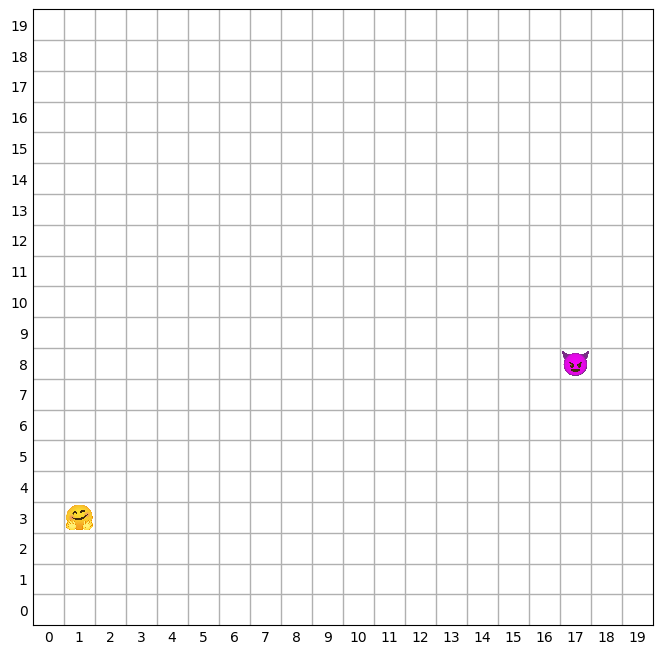


Game State:
+-----------------+---------------------+---------------------+
|    Attribute    |        Player       |        Enemy        |
+-----------------+---------------------+---------------------+
|      Health     |        100.0        |        100.0        |
|  Action Points  |         3.0         |         3.0         |
| Movement Points |         10.0        |         10.0        |
|     Location    |        (1, 3)       |       (17, 8)       |
|     Distance    |      16.763054      |                     |
|       Turn      |          0          |                     |
|      Steps      |          0          |                     |
|    Pick Mode    |         Yes         |                     |
|  Ability Slot 0 | ID: 1 (CD: 0.0/1.0) | ID: 2 (CD: 0.0/1.0) |
|  Ability Slot 1 |        Empty        |        Empty        |
+-----------------+---------------------+---------------------+

Available Actions:
+-----------+----------------------------+-----------+
| Action ID |   

In [ ]:
test_game = TestGame(test["runner_state"][0][0][0], train_config)

In [ ]:
test_game.player_action(11)

In [ ]:
test_game.player_action(7)

In [ ]:
test_game.player_action(7)

In [ ]:
test_game.player_action(7)

In [ ]:
test_game.player_action(7)

In [ ]:
test_game.player_action(7)

In [ ]:
test_game.player_action(6)

In [ ]:
test_game.player_action(6)

In [ ]:
test_game.player_action(10)

In [ ]:
test_game.env.num_actions

In [ ]:
test_game.state.units.available_actions

In [ ]:
test_game.player_action(15)

In [ ]:
test_game.player_action(7)

In [ ]:
test_game.player_action(7)

In [ ]:
test_game.player_action(4)

In [ ]:
test_game.player_action(4)

In [ ]:
test_game.player_action(4)

In [ ]:
test_game.player_action(4)

In [ ]:
test_game.player_action(8)

In [ ]:
test_game.player_action(10)